# Headlines & High Waters Player Visualizations

In [ ]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
import zipfile
from datetime import datetime
from dateutil import parser
import datetime
import ast
import json
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns
#from OGDUtils.general.fileio import FileAPI, FileTypes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Setup

### Retrieve Data Files
#### Please change the settings below to configure which game/server location you want to use.


*   game_id : The game whose data you want to access.
*   mode : The kind of data you want to retrieve. Should be one of FileTypes.PLAYER, FileTypes.POPULATION, FileTypes.SESSION, FileTypes.EVENTS or FileTypes.ALL_EVENTS



In [ ]:
# game_id = 'JOURNALISM'
# mode    = FileTypes.PLAYER

In [ ]:
# months_list = FileAPI.GetAvailableMonths(game_id)
# print(f"The available months are:")
# pprint(months_list, compact=True)

In [ ]:
# month = 2
# year = 2023

# download the file if it doesn't exist.
# zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)
# zip_name = zip_file.filename

In [ ]:
# raw_data = pd.DataFrame()

# ###
# #  To use file(s) from website, uncomment the lines in previous cell and delete these.
# file_path = 'JOURNALISM_20230401_to_20230425_7e4c492_player-features.zip'
# dataset_name = 'JOURNALISM_20230401_to_20230425'
# zip_file = ZipFile(file_path)
# zip_name = zip_file.filename
# ###

# MAX_ROWS = 10000 # for the sake of not overwhelming RAM, only read first 10,000 rows of a file. Feel free to increase

# # Open TSV from the zip file.
# tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
# with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
#     raw_data = pd.read_csv(tsv_file, sep='\t', nrows=MAX_ROWS)
#     data_readme = zip_file.read(f"{dataset_name}/readme.md")
# zip_file.close()

In [ ]:

file_path = 'JOURNALISM_20230929_to_20231002_5ba1dc6_player-features.tsv'
raw_data = pd.read_csv(file_path, sep='\t')


In [ ]:
df_session = raw_data.dropna()
for col in df_session.columns:
    dtype = df_session[col].dtype
    if dtype == bool:
        df_session[col] = df_session[col].astype(int)

def convert_to_seconds(time_str):
    try:
        time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S.%f').time()
        timedelta_obj = datetime.timedelta(hours=time_obj.hour, minutes=time_obj.minute, seconds=time_obj.second, microseconds=time_obj.microsecond)
        return timedelta_obj.total_seconds()
    except ValueError:
        return None

df_session['UserPlayTime'] = df_session['UserPlayTime'].apply(convert_to_seconds)
df_session['UserPlayTime-Active'] = df_session['UserPlayTime-Active'].apply(convert_to_seconds)


## Visualizations

### Quit Types

BetweenLevels     4
OnFail           27
Other            55
Name: QuitType, dtype: int64
BetweenLevels    0
OnFail           2
Other            5
Name: QuitType, dtype: int64
BetweenLevels     0
OnFail            2
Other            13
Name: QuitType, dtype: int64
BetweenLevels    0
OnFail           0
Other            1
Name: QuitType, dtype: int64
BetweenLevels     0
OnFail            2
Other            10
Name: QuitType, dtype: int64


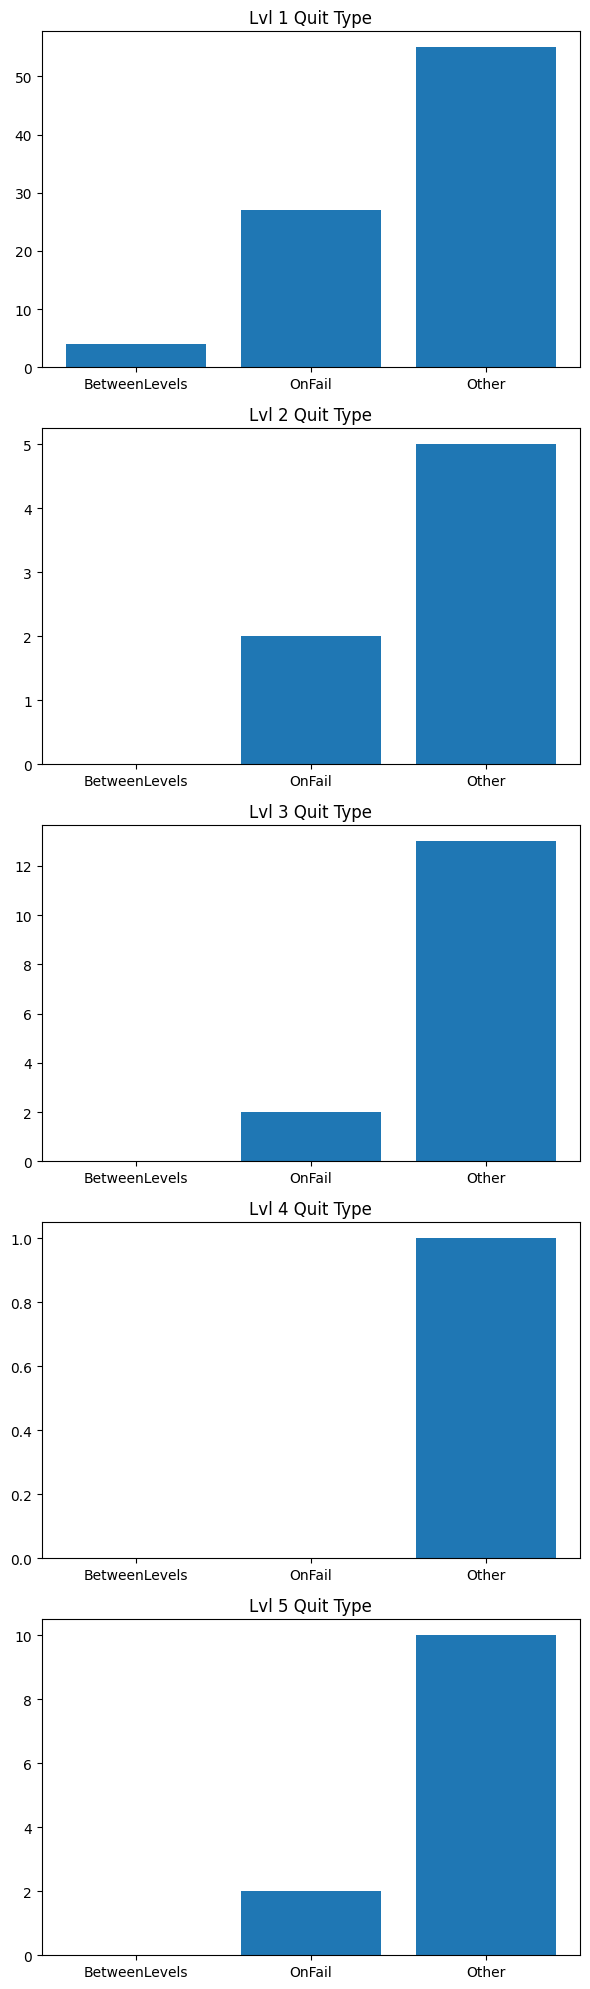

In [ ]:
quit_types = sorted(df_session['QuitType'].unique())
fig, axs = plt.subplots(5, 1, figsize=(6, 20))

bins = 3
x_ticks = np.arange(len(quit_types))
x_tick_labels = quit_types

for i, ax in enumerate(axs):
    fail_level = i + 1
    fail_data = df_session[df_session[f'lvl{fail_level}_FailureCount'] > 0]
    df_column = fail_data['QuitType']
    quit_type_counts = df_column.value_counts().reindex(quit_types, fill_value=0)
    print(quit_type_counts)
    ax.bar(x_ticks, quit_type_counts, align='center')
    ax.set_title(f"Lvl {fail_level} Quit Type")

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

fig.tight_layout()
plt.show()

### Player Times

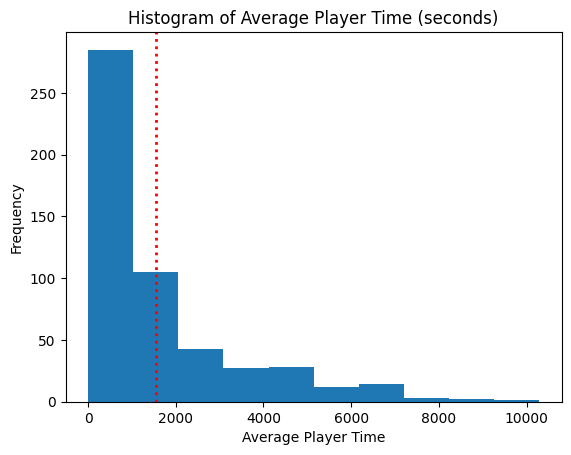

Average time: 25.909445064102563 minutes


In [ ]:
plt.hist(df_session['UserPlayTime-Active'], bins=10)
plt.axvline(x=df_session['UserPlayTime-Active'].mean(), color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Average Player Time')
plt.ylabel('Frequency')
plt.title('Histogram of Average Player Time (seconds)')
plt.show()
print(f'Average time: {df_session["UserPlayTime-Active"].mean() / 60} minutes')

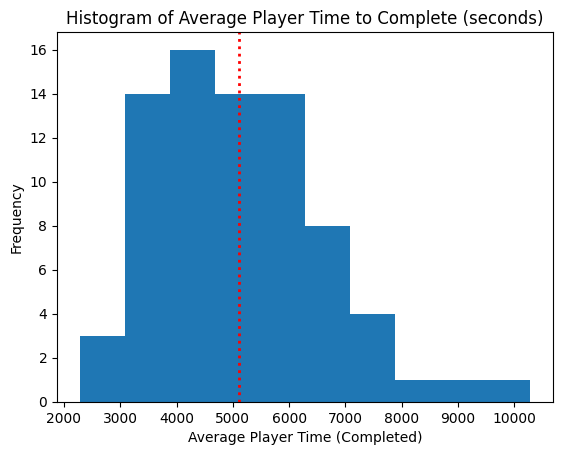

Average time: 85.03122938596492 minutes


In [ ]:
df_completed = df_session[df_session['GameComplete'] == 1]
plt.hist(df_completed['UserPlayTime-Active'], bins=10)
plt.axvline(x=df_completed['UserPlayTime-Active'].mean(), color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Average Player Time (Completed)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Player Time to Complete (seconds)')
plt.show()
print(f'Average time: {df_completed["UserPlayTime-Active"].mean() / 60} minutes')

### Average Attributes

In [ ]:
df_played_well = df_session[df_session['TotalFails'] < 50 ]
json_str = df_session['SkillSequenceCount-Event Sequence']
parsed_json_object_1 = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_object_1.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_object_1:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Well Played Games'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig

In [ ]:
json_str = df_completed['SkillSequenceCount-Event Sequence']
parsed_json_objects = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_objects.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_objects:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Completed Games'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig

{'Research': 1.4342105263157894, 'Resourceful': 3.0657894736842106, 'Endurance': 3.8552631578947367, 'Tech': 2.5526315789473686, 'Social': 2.0, 'Trust': 2.1842105263157894}


In [ ]:
df_no_finish = df_session[df_session['GameComplete'] == 0]
json_str = df_no_finish['SkillSequenceCount-Event Sequence']
parsed_json_objects = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_objects.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_objects:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Games that were not Completed'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig


{'Research': 0.24719101123595505, 'Resourceful': 1.2719101123595506, 'Endurance': 0.6808988764044944, 'Tech': 0.9011235955056179, 'Social': 0.849438202247191, 'Trust': 0.8359550561797753}


In [ ]:
len(df_completed)

76

### Attribute Distributions

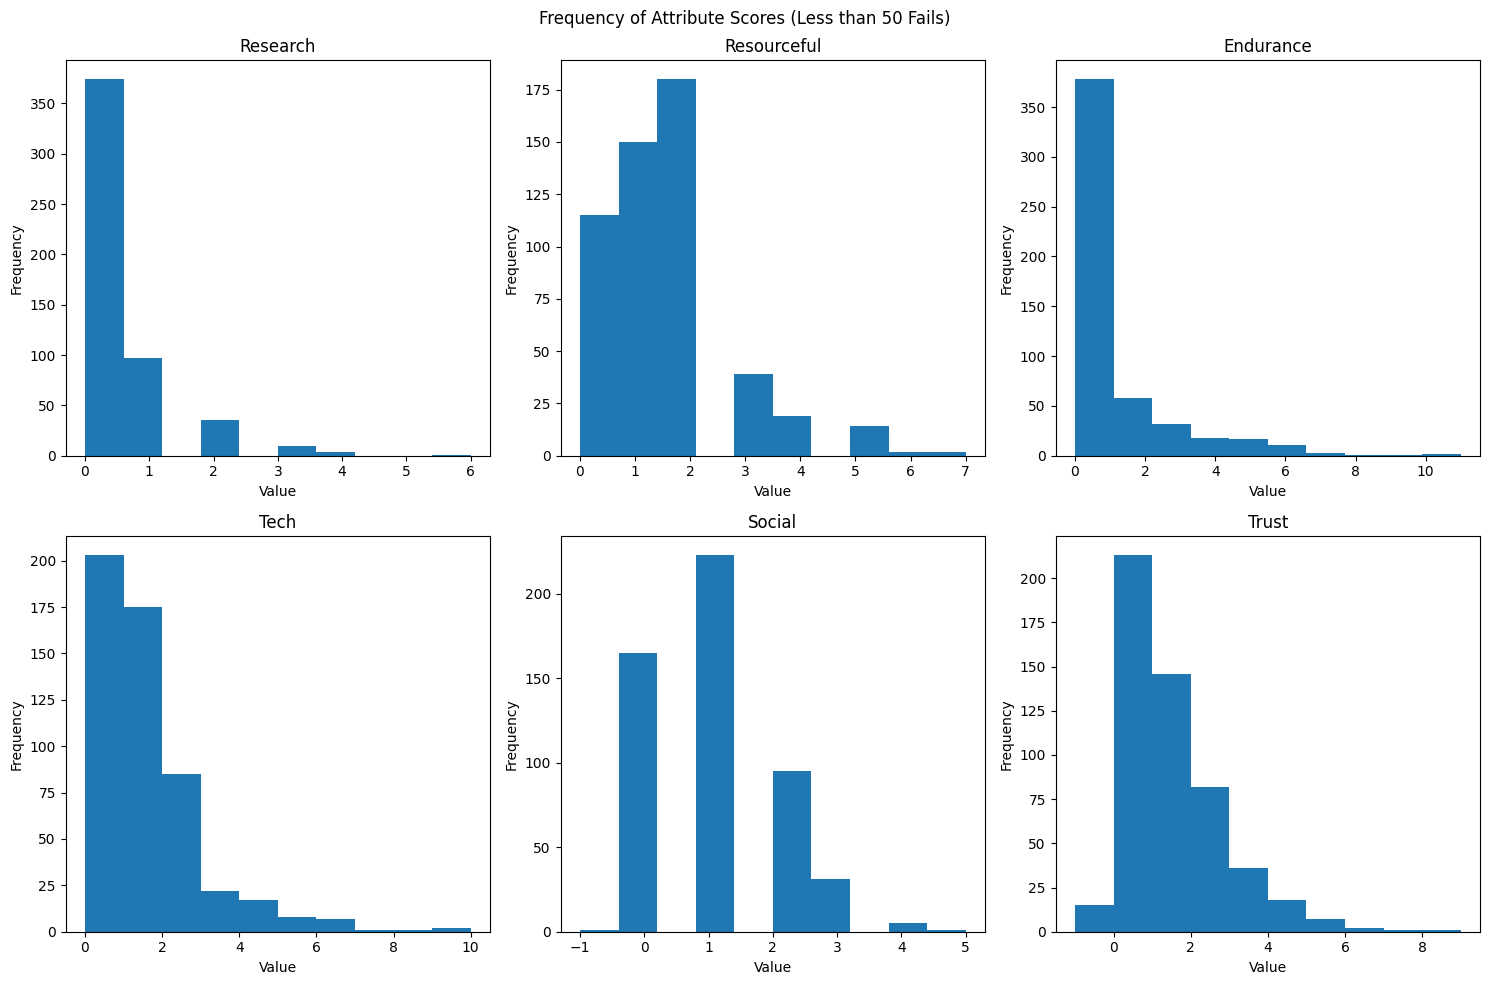

In [ ]:
attributes = ["Research", "Resourceful", "Endurance", "Tech", "Social", "Trust"]
final_values = []

for sublist in parsed_json_object_1:
    total_skill = {
        "Research": 0,
        "Resourceful": 0,
        "Endurance": 0,
        "Tech": 0,
        "Social": 0,
        "Trust": 0
    }
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value

    final_values.append(list(total_skill.values()))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Frequency of Attribute Scores (Less than 50 Fails)")

for i, attribute in enumerate(attributes):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    ax.hist([values[i] for values in final_values])
    ax.set_title(attribute)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Failure Types

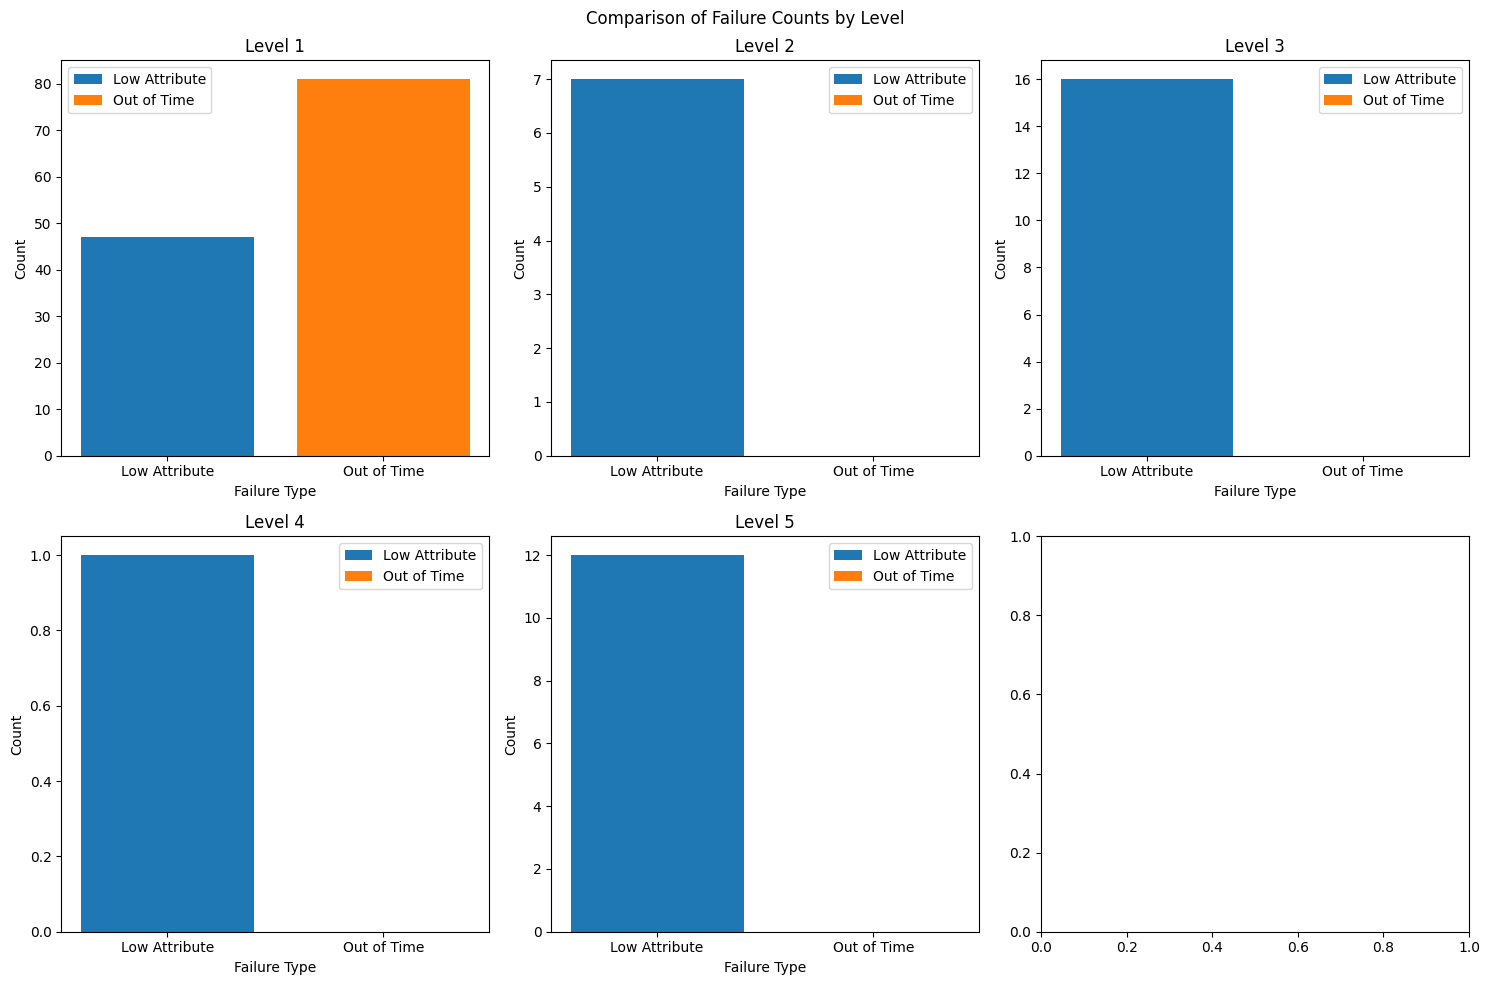

In [ ]:
df_failure = df_session[df_session['TotalFails'] < 10]

def bar_graph(df_1, df_2, level, ax):
    ax.bar('Low Attribute', df_1.sum(), label='Low Attribute')
    ax.bar('Out of Time', df_2.sum(), label='Out of Time')
    ax.set_xlabel('Failure Type')
    ax.set_ylabel('Count')
    ax.set_title(f'Level {level}')
    ax.legend()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Failure Counts by Level")

for level in range(1, 6):
    row = (level - 1) // 3
    col = (level - 1) % 3
    ax = axs[row, col]

    bar_graph(
        df_failure[f'lvl{level}_FailureCount-LowAttribute'],
        df_failure[f'lvl{level}_FailureCount-OutOfTime'],
        level,
        ax
    )

plt.tight_layout()
plt.show()

### Attribute Progressions

In [ ]:
# choose which user you want to look at, change index at the end
json_string = df_session['SkillSequenceCount-Event Sequence'][6]

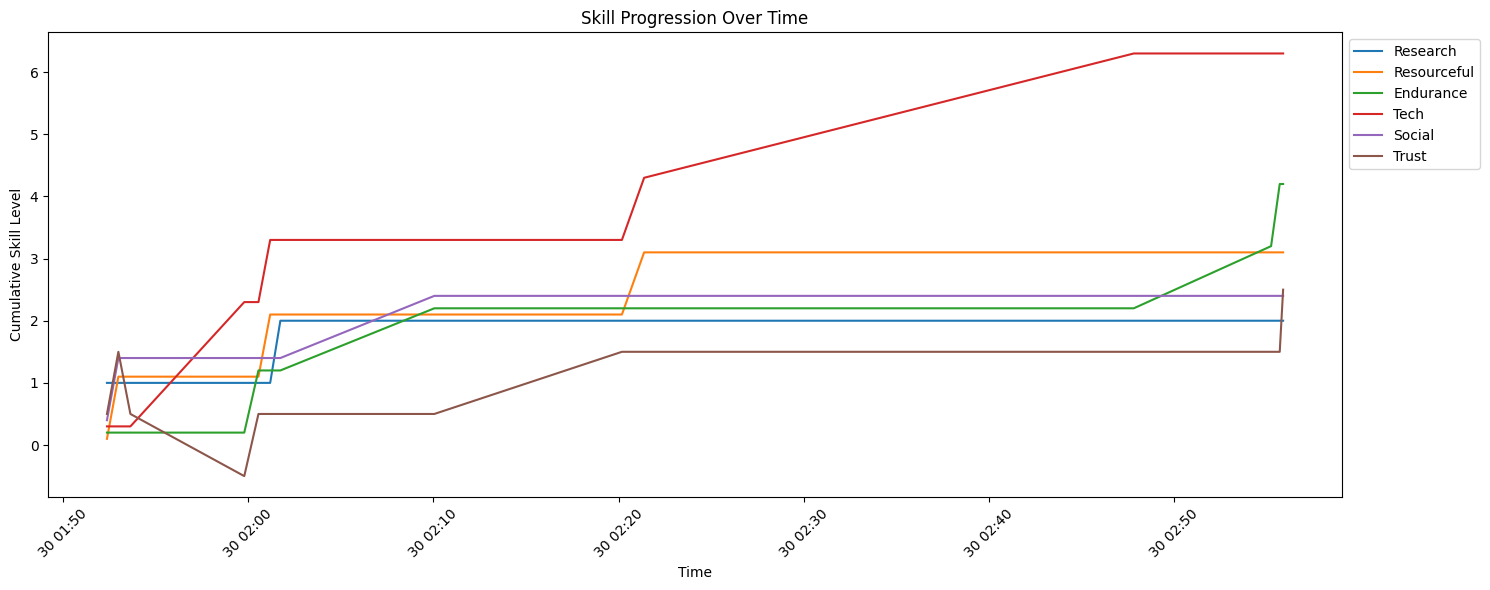

Final Scores: {'Research': 2.0, 'Resourceful': 3.1, 'Endurance': 4.2, 'Tech': 6.3, 'Social': 2.4, 'Trust': 2.5}


In [ ]:
data = json.loads(json_string)
skill_names = ["Research", "Resourceful", "Endurance", "Tech", "Social", "Trust"]

skill_data = {skill_name: {"time": [], "level": []} for skill_name in skill_names}

cumulative_levels = {skill_name: 0.1 * i for i, skill_name in enumerate(skill_names)}

for item in data:
    time = parser.parse(item["time"])
    skill_values = json.loads(item["skill"])

    for skill_name, level in skill_values.items():
        cumulative_levels[skill_name] += level
        skill_data[skill_name]["time"].append(time)
        skill_data[skill_name]["level"].append(cumulative_levels[skill_name])

plt.figure(figsize=(15, 6))
plt.title("Skill Progression Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Skill Level")

for skill_name, skill_values in skill_data.items():
    plt.plot(skill_values["time"], skill_values["level"], label=skill_name)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



print(f'Final Scores: {cumulative_levels}')

### Story & Alignment Scores

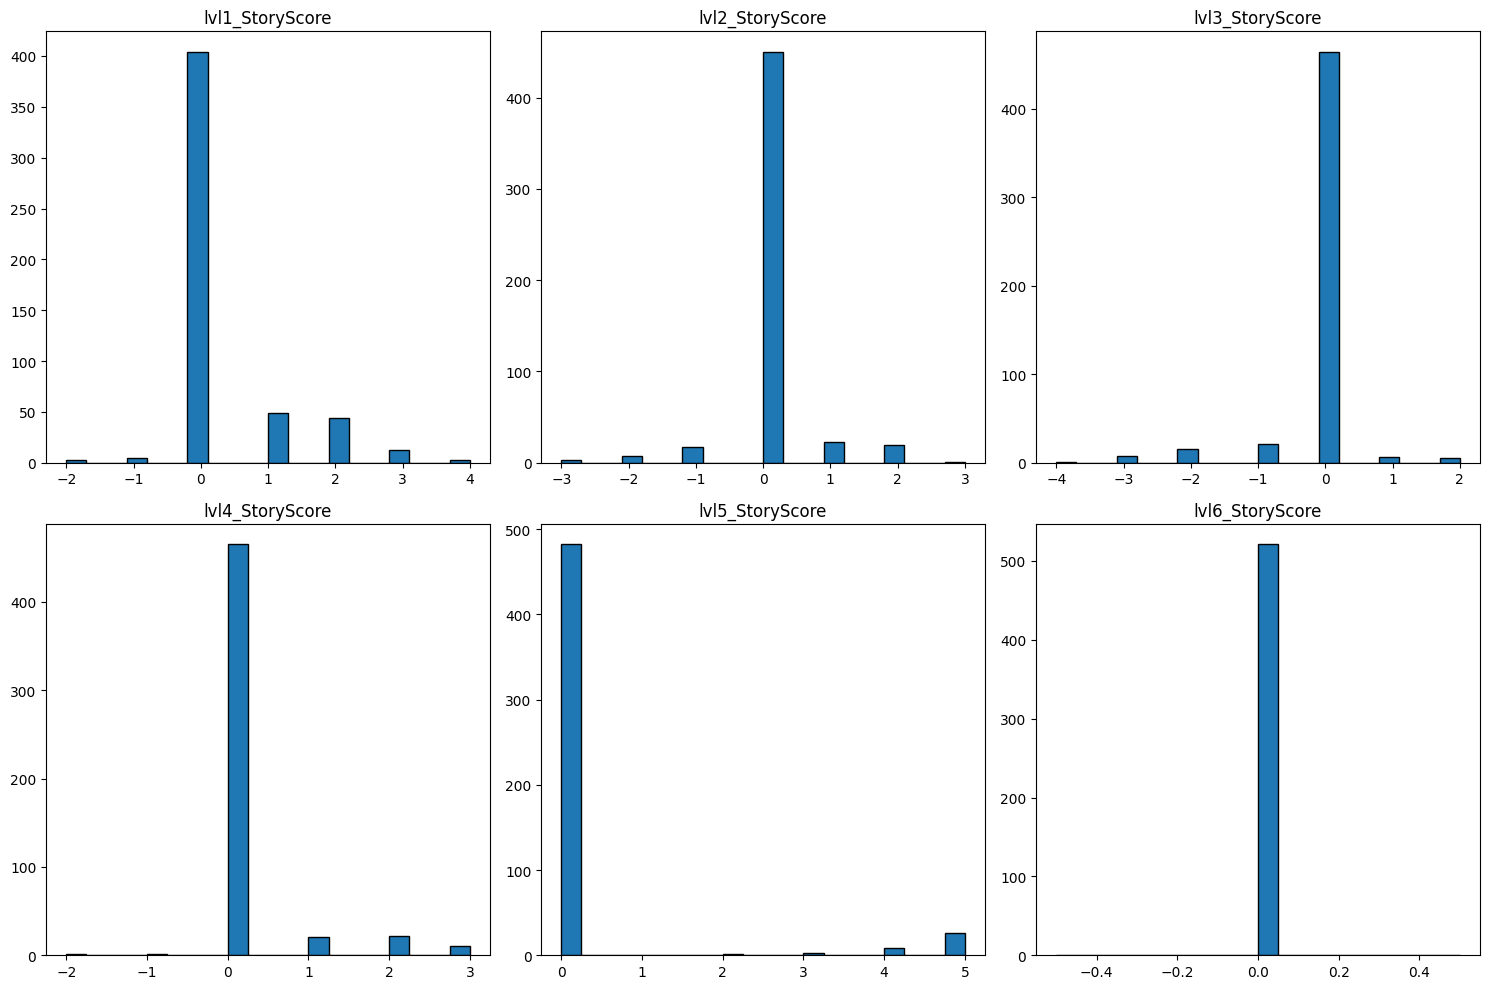

In [ ]:
file_path = 'JOURNALISM_20230929_to_20231002_5ba1dc6_player-features.tsv'
df = pd.read_csv(file_path, sep='\t')
df_completed_2 = df[df['GameComplete'] == True]
df_storyscore = df[['lvl1_StoryScore', 'lvl2_StoryScore', 'lvl3_StoryScore', 'lvl4_StoryScore', 'lvl5_StoryScore', 'lvl6_StoryScore']]
df_storyscore_complete = df_completed_2[['lvl1_StoryScore', 'lvl2_StoryScore', 'lvl3_StoryScore', 'lvl4_StoryScore', 'lvl5_StoryScore', 'lvl6_StoryScore']]

df_storyalignment = df[['lvl1_StoryAlignment',	'lvl2_StoryAlignment', 'lvl3_StoryAlignment',	'lvl4_StoryAlignment',	'lvl5_StoryAlignment',	'lvl6_StoryAlignment']]
df_storyalignment_complete = df_completed_2[['lvl1_StoryAlignment',	'lvl2_StoryAlignment', 'lvl3_StoryAlignment',	'lvl4_StoryAlignment',	'lvl5_StoryAlignment',	'lvl6_StoryAlignment']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(df_storyscore.columns):
    axes[i].hist(df[column], bins=20, edgecolor='black')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

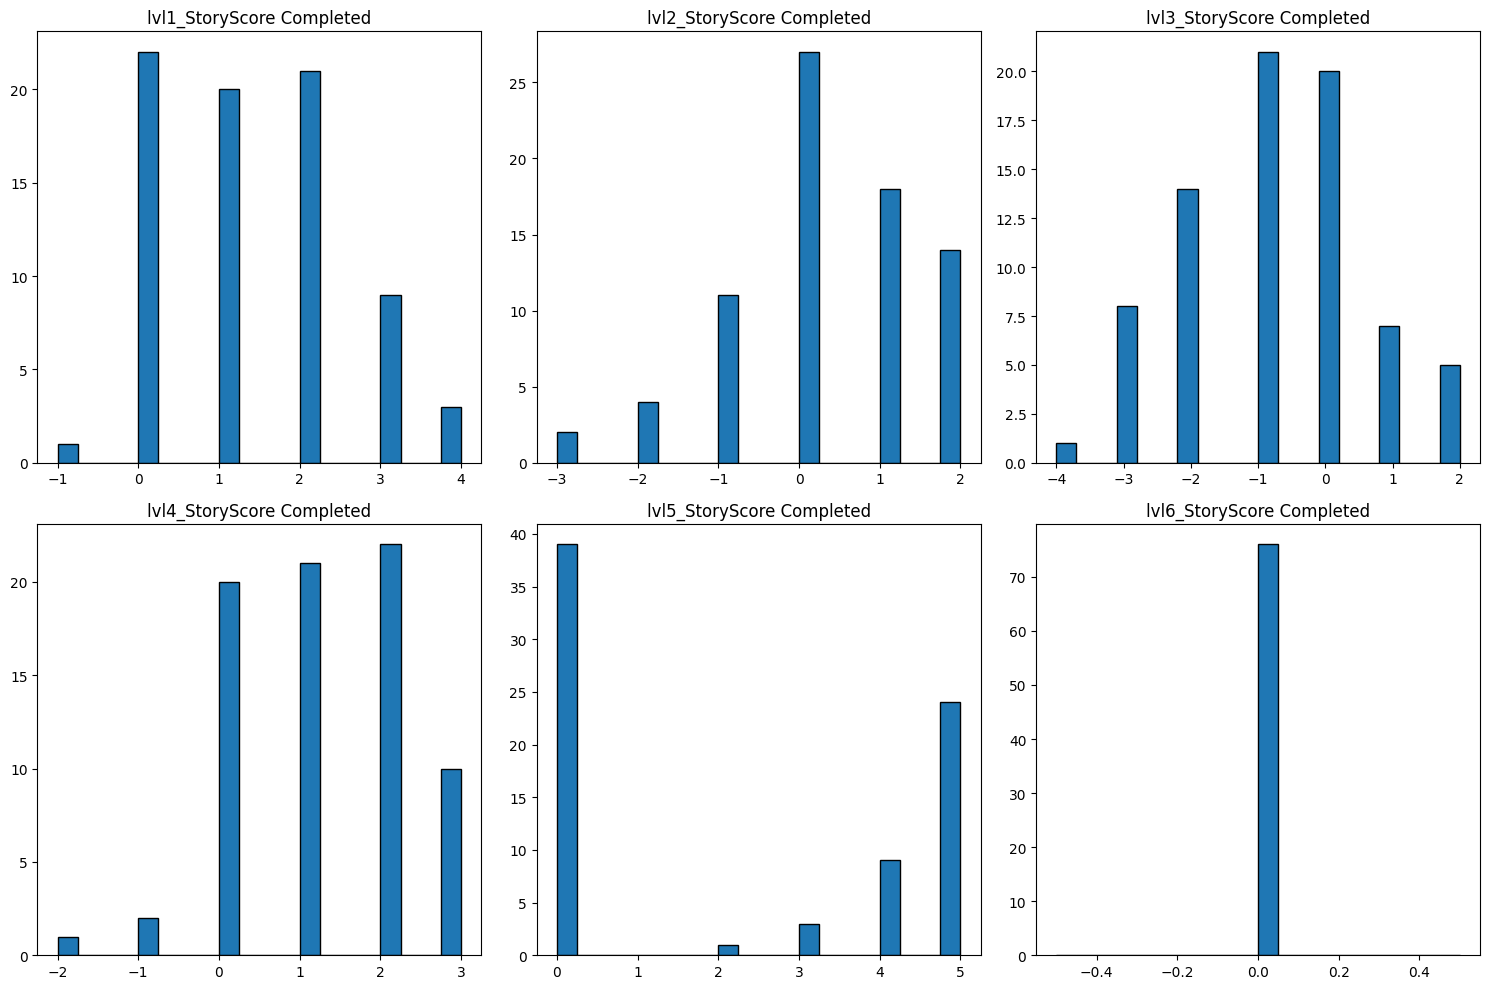

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(df_storyscore_complete.columns):
    axes[i].hist(df_storyscore_complete[column], bins=20, edgecolor='black')
    axes[i].set_title(f'{column} Completed')

plt.tight_layout()
plt.show()

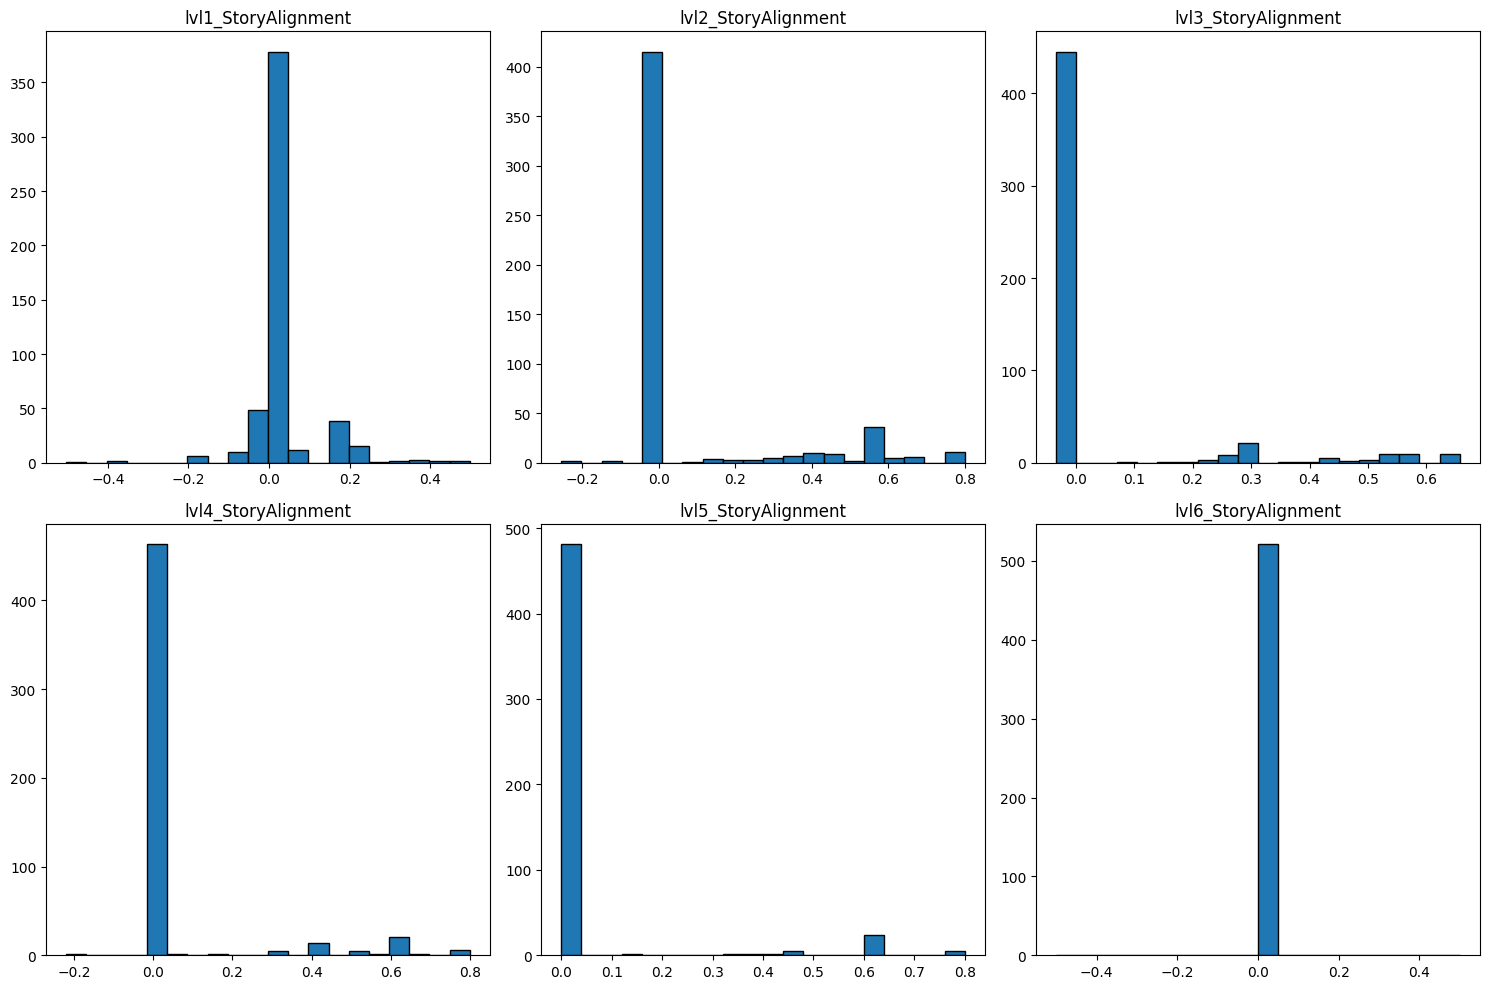

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(df_storyalignment.columns):
    axes[i].hist(df[column], bins=20, edgecolor='black')
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

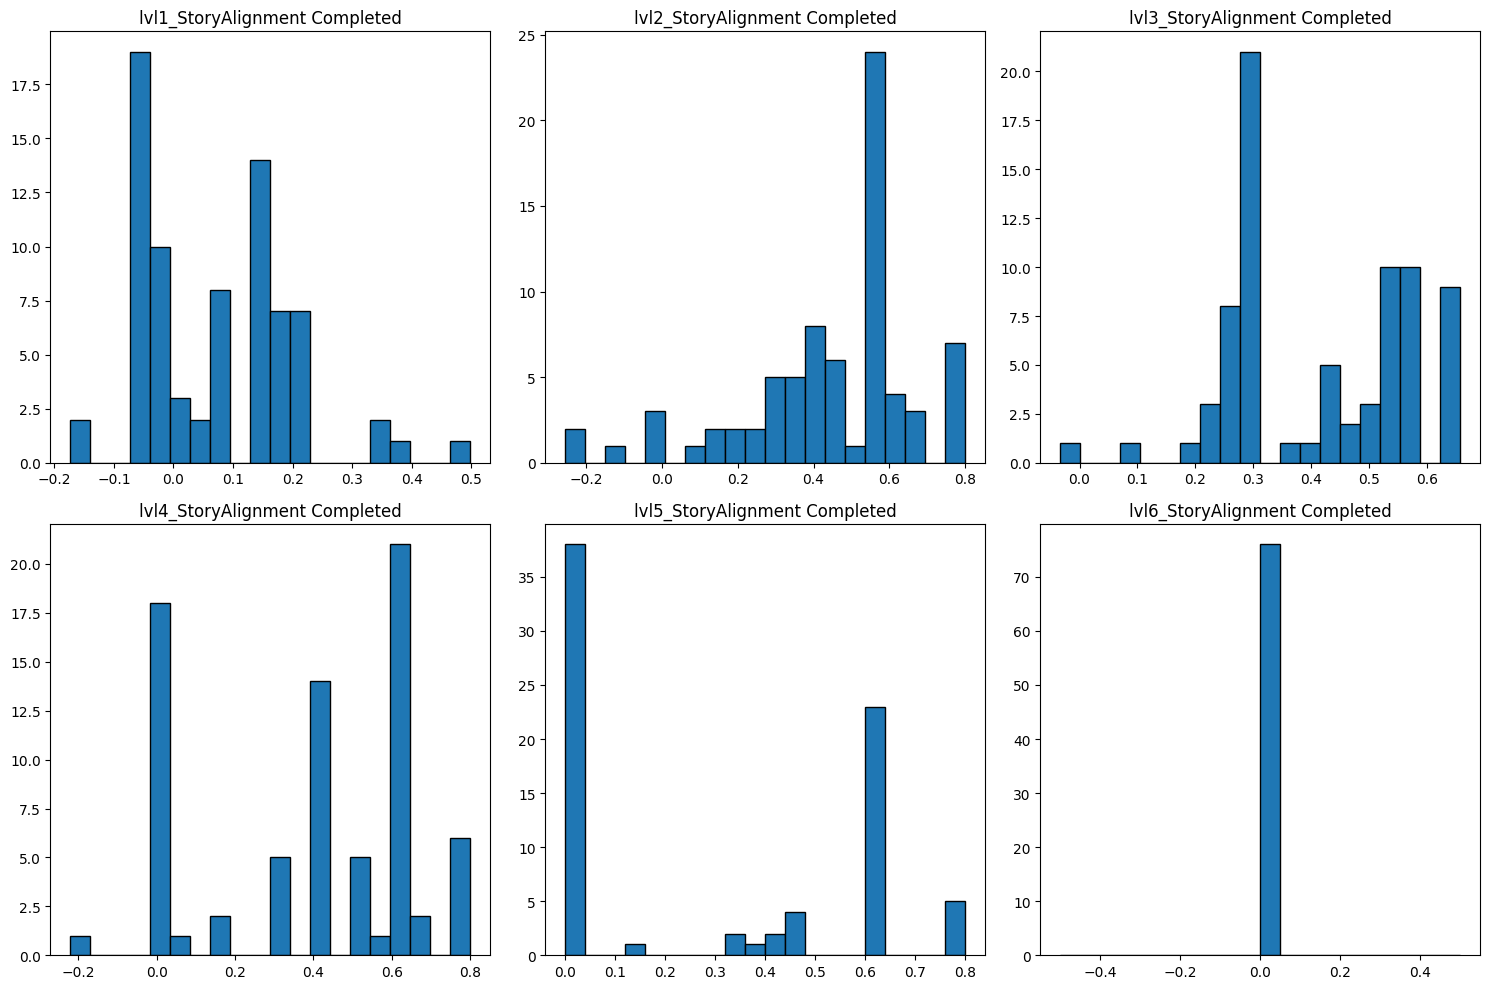

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(df_storyalignment_complete.columns):
    axes[i].hist(df_storyalignment_complete[column], bins=20, edgecolor='black')
    axes[i].set_title(f'{column} Completed')

plt.tight_layout()
plt.show()

### Snippets Collected & Submitted

In [ ]:
for i in range(1, 7):
    column_name = f'lvl{i}_SnippetsCollected'
    df[column_name] = df[column_name].apply(ast.literal_eval)

In [ ]:
common_snippets_dict = {}
for i in range(1, 7):
    column_name = f'lvl{i}_SnippetsCollected'

    counter = Counter([snippet for snippet_list in df[column_name] for snippet in snippet_list])

    most_common = counter.most_common(10)

    common_snippets_dict[column_name] = most_common


{'lvl1_SnippetsCollected': [('@932A76D4', 87),
  ('@CB19BD38', 75),
  ('@C22C685F', 60),
  ('@B7A5E498', 59),
  ('@8228E43A', 59),
  ('@3A9CA0E7', 49),
  ('@CAAE645C', 42),
  ('@D55E703E', 37),
  ('@67FC07A9', 35),
  ('@BDDCD221', 24)],
 'lvl2_SnippetsCollected': [('@620E6928', 76),
  ('@EB9ACCCF', 70),
  ('@39AE4E5F', 66),
  ('@11F1B0E8', 65),
  ('@D632286E', 48),
  ('@07CEC29F', 48),
  ('@03C9AFF9', 44),
  ('@EE30D857', 43),
  ('@912E9C4A', 34),
  ('@97862C39', 30)],
 'lvl3_SnippetsCollected': [('@2072DF3F', 88),
  ('@C10E0BDE', 53),
  ('@F141D9AB', 48),
  ('@D0C1271D', 42),
  ('@E7FE163C', 42),
  ('@51212A4C', 37),
  ('@F4315E91', 33),
  ('@9EB5E286', 29),
  ('@D58E05F7', 18),
  ('@6AA30C08', 15)],
 'lvl4_SnippetsCollected': [('@2EA73652', 57),
  ('@0D535724', 46),
  ('@47624F3F', 39),
  ('@632DB3E3', 38),
  ('@0A20F054', 22),
  ('@1F78F07A', 21),
  ('@E8E605E5', 16),
  ('@06B8B698', 14),
  ('@DD369B74', 13),
  ('@746A9FEE', 12)],
 'lvl5_SnippetsCollected': [('@2FA796DD', 53),
  ('@

In [ ]:
for i in range(1, 7):
    column_name = f'lvl{i}_LevelCompleted'
    df[column_name] = df[column_name].astype(int)
    counter = df[column_name].value_counts()
    print(counter)

    print()

0    376
1    145
Name: lvl1_LevelCompleted, dtype: int64

0    417
1    104
Name: lvl2_LevelCompleted, dtype: int64

0    444
1     77
Name: lvl3_LevelCompleted, dtype: int64

0    457
1     64
Name: lvl4_LevelCompleted, dtype: int64

0    480
1     41
Name: lvl5_LevelCompleted, dtype: int64

0    521
Name: lvl6_LevelCompleted, dtype: int64



### Levels Completed

In [ ]:
# amount of people that complete the game
len(df_completed_2)

76

   lvl1_LevelCompleted  lvl2_LevelCompleted  lvl3_LevelCompleted  \
0                  376                  417                  444   
1                  145                  104                   77   

   lvl4_LevelCompleted  lvl5_LevelCompleted  
0                  457                  480  
1                   64                   41  


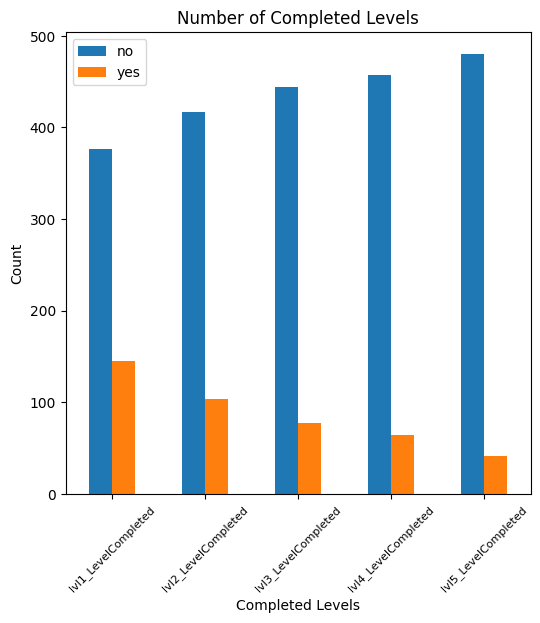

In [ ]:
target_cols = ['lvl1_LevelCompleted', 'lvl2_LevelCompleted', 'lvl3_LevelCompleted', 'lvl4_LevelCompleted', 'lvl5_LevelCompleted']

counts = df[target_cols].apply(pd.Series.value_counts)
print(counts)
fig, ax = plt.subplots(figsize=(6, 6))
counts.T.plot(kind='bar', ax=ax)
legend_labels = ['no', 'yes']
ax.legend(labels=legend_labels)

ax.set_xlabel('Completed Levels')
ax.set_ylabel('Count')
ax.set_title('Number of Completed Levels')
plt.xticks(rotation=45, fontsize=8)


plt.show()

### Session Counts per-Player

461 out of 521 players had only one session


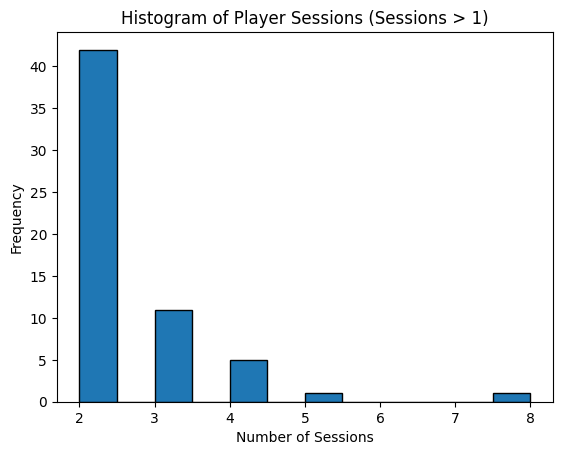

In [ ]:
len(df['SessionCount'].unique())
session_df = df[df['SessionCount'] > 1]
equal_one = df[df['SessionCount'] == 1]
print(f'{len(equal_one)} out of {len(df)} players had only one session')

plt.hist(session_df['SessionCount'], bins=12, edgecolor='black')
plt.xlabel('Number of Sessions')
plt.ylabel('Frequency')
plt.title('Histogram of Player Sessions (Sessions > 1)')
plt.show()

50 out of 76 players had only one session


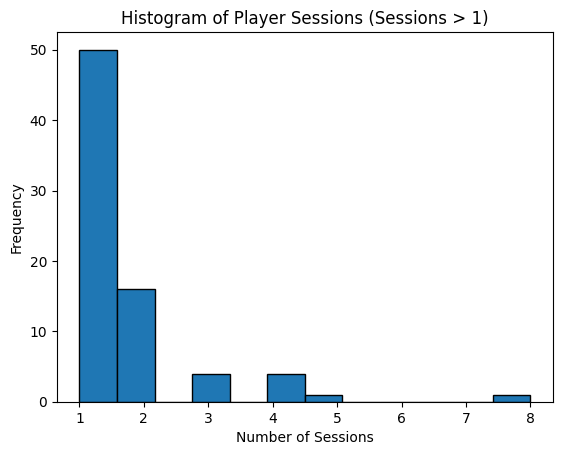

In [ ]:
len(df_completed_2['SessionCount'].unique())
session_df = df_completed_2[df_completed_2['SessionCount'] > 1]
equal_one = df_completed_2[df_completed_2['SessionCount'] == 1]
print(f'{len(equal_one)} out of {len(df_completed_2)} players had only one session')

plt.hist(df_completed_2['SessionCount'], bins=12, edgecolor='black')
plt.xlabel('Number of Sessions')
plt.ylabel('Frequency')
plt.title('Histogram of Player Sessions (Sessions > 1)')
plt.show()


In [ ]:
df_lvl1 = df[df['lvl1_LevelCompleted'] == 1]
df_lvl2 = df[df['lvl2_LevelCompleted'] == 1]
df_lvl3 = df[df['lvl3_LevelCompleted'] == 1]
df_lvl4 = df[df['lvl4_LevelCompleted'] == 1]
df_lvl5 = df[df['lvl5_LevelCompleted'] == 1]

### Best-Worst Attribute Comparisons

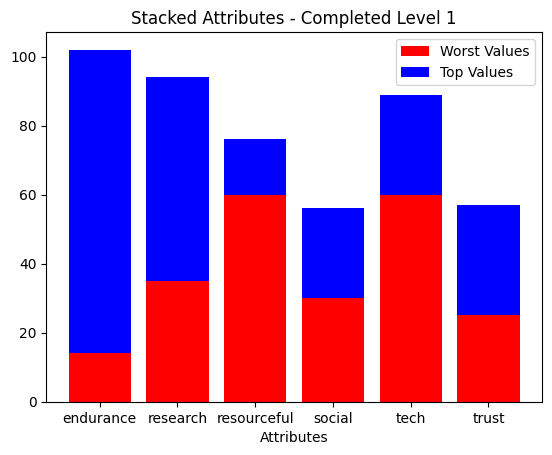

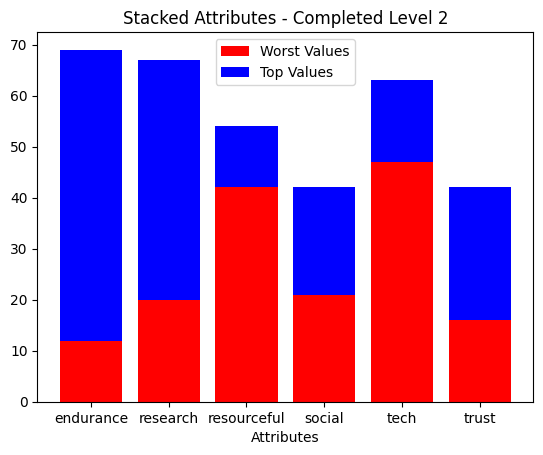

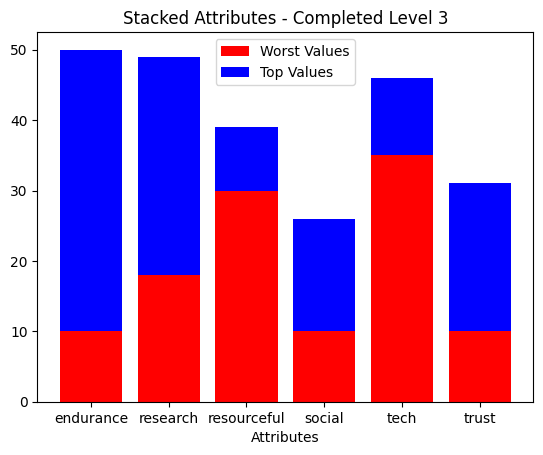

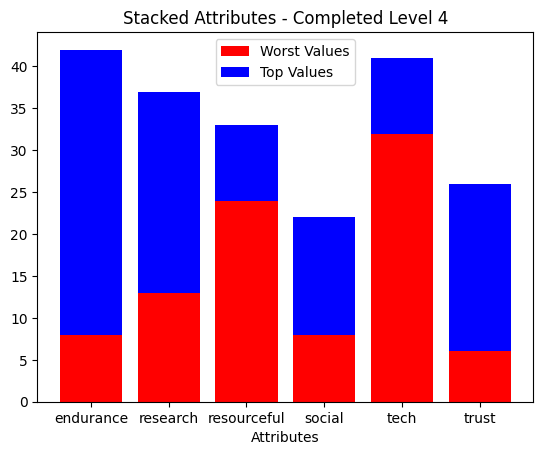

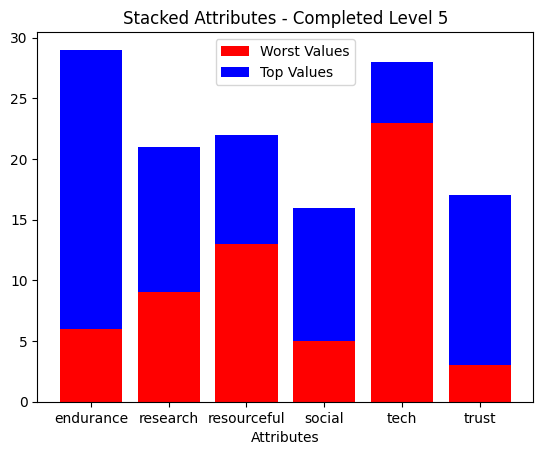

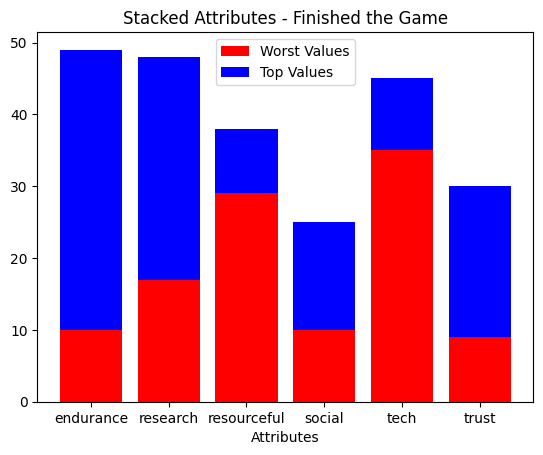

In [ ]:
def calculate_counts(data_frame, attribute_column):
    attribute_counts = {}
    for group in data_frame[attribute_column]:
        group = ast.literal_eval(group)
        for value in group:
            if value in attribute_counts:
                attribute_counts[value] += 1
            else:
                attribute_counts[value] = 1
    return attribute_counts

data_frames = {
    "Completed Level 1": df_lvl1,
    "Completed Level 2": df_lvl2,
    "Completed Level 3": df_lvl3,
    "Completed Level 4": df_lvl4,
    "Completed Level 5": df_lvl5,
    "Finished the Game": df_completed_2
}

for name, data_frame in data_frames.items():
    top_counts = calculate_counts(data_frame, "TopAttribute-Names")
    worst_counts = calculate_counts(data_frame, "WorstAttribute-Names")

    sorted_keys = sorted(top_counts.keys())
    sorted_dict1 = {key: top_counts[key] for key in sorted_keys}
    sorted_dict2 = {key: worst_counts[key] for key in sorted_keys}
    x_label = sorted_dict1.keys()
    worst_values = list(sorted_dict2.values())
    top_values = list(sorted_dict1.values())

    plt.figure()
    plt.bar(x_label, top_values, color='r', label='Worst Values')
    plt.bar(x_label, worst_values, bottom=top_values, color='b', label='Top Values')

    plt.xlabel('Attributes')
    plt.title('Stacked Attributes - ' + name)
    plt.legend()

In [ ]:
json_str = df_completed_2['SkillSequenceCount-Event Sequence']
parsed_json_objects = []
for string in json_str:
    parsed_json = json.loads(string)
    parsed_json_objects.append(parsed_json)

total_skill = {
    "Research": 0,
    "Resourceful": 0,
    "Endurance": 0,
    "Tech": 0,
    "Social": 0,
    "Trust": 0
}

num_items = 0
for sublist in parsed_json_objects:
    for obj in sublist:
        skill_json = json.loads(obj["skill"])
        for key, value in skill_json.items():
            total_skill[key] += value
    num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

labels = list(average_scores.keys())
values = list(average_scores.values())
categories = [*labels, labels[0]]
values = [*values, values[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=values, theta=categories, name='Average Score'),
      ],
    layout=go.Layout(
        title=go.layout.Title(text='Attribute Comparison for Completed Games'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

print(average_scores)
fig

{'Research': 1.4342105263157894, 'Resourceful': 3.0657894736842106, 'Endurance': 3.8552631578947367, 'Tech': 2.5526315789473686, 'Social': 2.0, 'Trust': 2.1842105263157894}


### Snippets Collected & Submitted Visualization

In [ ]:
combined_result_dict = {}

for i in range(1, 7):
    snippet_collected_column = df_session[f'lvl{i}_SnippetsCollected']
    qualities_column = df_session[f'lvl{i}_SnippetsCollected-Qualities']

    result_dict = {}

    for snippet, quality in zip(snippet_collected_column, qualities_column):
        snippet = snippet.strip('[]').replace('"', '')
        quality = quality.strip('[]').replace('"', '')

        snippets = snippet.split(', ')
        qualities = quality.split(', ')

        for s, q in zip(snippets, qualities):
            result_dict[s] = q

    combined_result_dict[f'lvl{i}'] = result_dict


In [ ]:
combined_dict = {}
for lvl, snippets in common_snippets_dict.items():
    lvl_number = lvl.split('_')[0]
    level_info = combined_result_dict.get(lvl_number, {})

    mapped_snippets = [(snippet, count, level_info.get(snippet, '')) for snippet, count in snippets]

    combined_dict[lvl] = mapped_snippets
combined_dict

{'lvl1_SnippetsCollected': [('@932A76D4', 87, 'Great'),
  ('@CB19BD38', 75, 'Good'),
  ('@C22C685F', 60, 'Good'),
  ('@B7A5E498', 59, 'Good'),
  ('@8228E43A', 59, 'Good'),
  ('@3A9CA0E7', 49, 'Great'),
  ('@CAAE645C', 42, 'Great'),
  ('@D55E703E', 37, 'Bad'),
  ('@67FC07A9', 35, 'Great'),
  ('@BDDCD221', 24, 'Good')],
 'lvl2_SnippetsCollected': [('@620E6928', 76, 'Good'),
  ('@EB9ACCCF', 70, 'Good'),
  ('@39AE4E5F', 66, 'Good'),
  ('@11F1B0E8', 65, 'Good'),
  ('@D632286E', 48, 'Bad'),
  ('@07CEC29F', 48, 'Bad'),
  ('@03C9AFF9', 44, 'Bad'),
  ('@EE30D857', 43, 'Great'),
  ('@912E9C4A', 34, 'Good'),
  ('@97862C39', 30, 'Great')],
 'lvl3_SnippetsCollected': [('@2072DF3F', 88, 'Bad'),
  ('@C10E0BDE', 53, 'Good'),
  ('@F141D9AB', 48, 'Good'),
  ('@D0C1271D', 42, 'Bad'),
  ('@E7FE163C', 42, 'Good'),
  ('@51212A4C', 37, 'Great'),
  ('@F4315E91', 33, 'Bad'),
  ('@9EB5E286', 29, 'Bad'),
  ('@D58E05F7', 18, 'Good'),
  ('@6AA30C08', 15, 'Bad')],
 'lvl4_SnippetsCollected': [('@2EA73652', 57, 'Grea

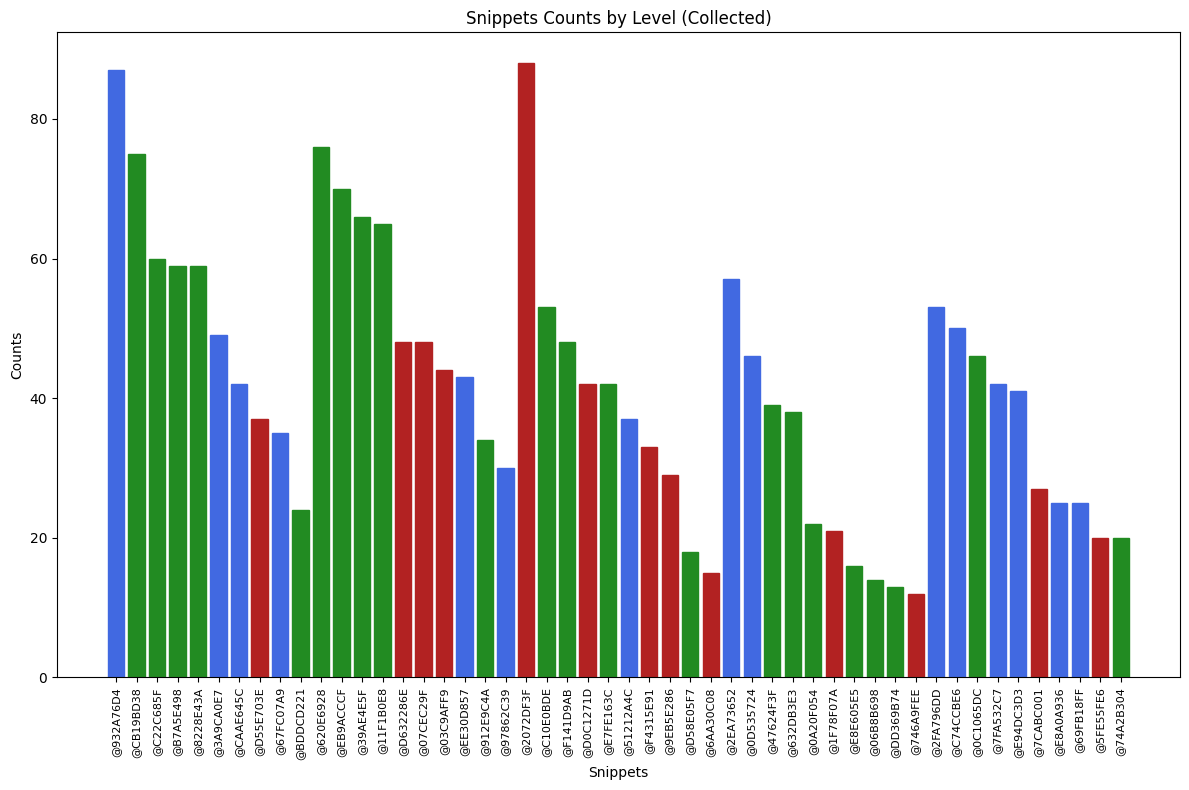

In [ ]:
category_colors = {'Great': 'royalblue', 'Good': 'forestgreen', 'Bad': 'firebrick'}

levels = []
snippets = []
counts = []
colors = []

for level, snippet_list in combined_dict.items():
    levels.extend([level] * len(snippet_list))
    snippet_data = [(snippet[0], snippet[1], snippet[2]) for snippet in snippet_list]
    snippets.extend([snippet[0] for snippet in snippet_data])
    counts.extend([snippet[1] for snippet in snippet_data])
    colors.extend([category_colors[snippet[2]] for snippet in snippet_data])

plt.figure(figsize=(12, 8), edgecolor='black')
bars = plt.bar(range(len(snippets)), counts, tick_label=snippets)

for bar, color in zip(bars, colors):
    bar.set_color(color)
plt.xlabel('Snippets')
plt.ylabel('Counts')
plt.title('Snippets Counts by Level (Collected)')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

plt.show()


In [ ]:
top_10_common_dict = {}

for level in range(1, 7):
    level_column_name = f'lvl{level}_SnippetsSubmitted'
    counter = Counter()

    for cell in df[level_column_name]:
        cell_list = [item.strip().strip('[]"') for item in cell.split(',') if item.strip()]
        for value in cell_list:
            if value:
                counter[value] += 1

    top_10_common = dict(counter.most_common(10))

    top_10_common_dict[level_column_name] = top_10_common


In [ ]:
combined_dict = {}

for lvl, snippets_count in top_10_common_dict.items():
    lvl_number = lvl.split('_')[0]
    level_info = combined_result_dict.get(lvl_number, {})

    mapped_snippets = {snippet: {"count": count, "info": level_info.get(snippet, '')} for snippet, count in snippets_count.items()}

    combined_dict[lvl] = mapped_snippets


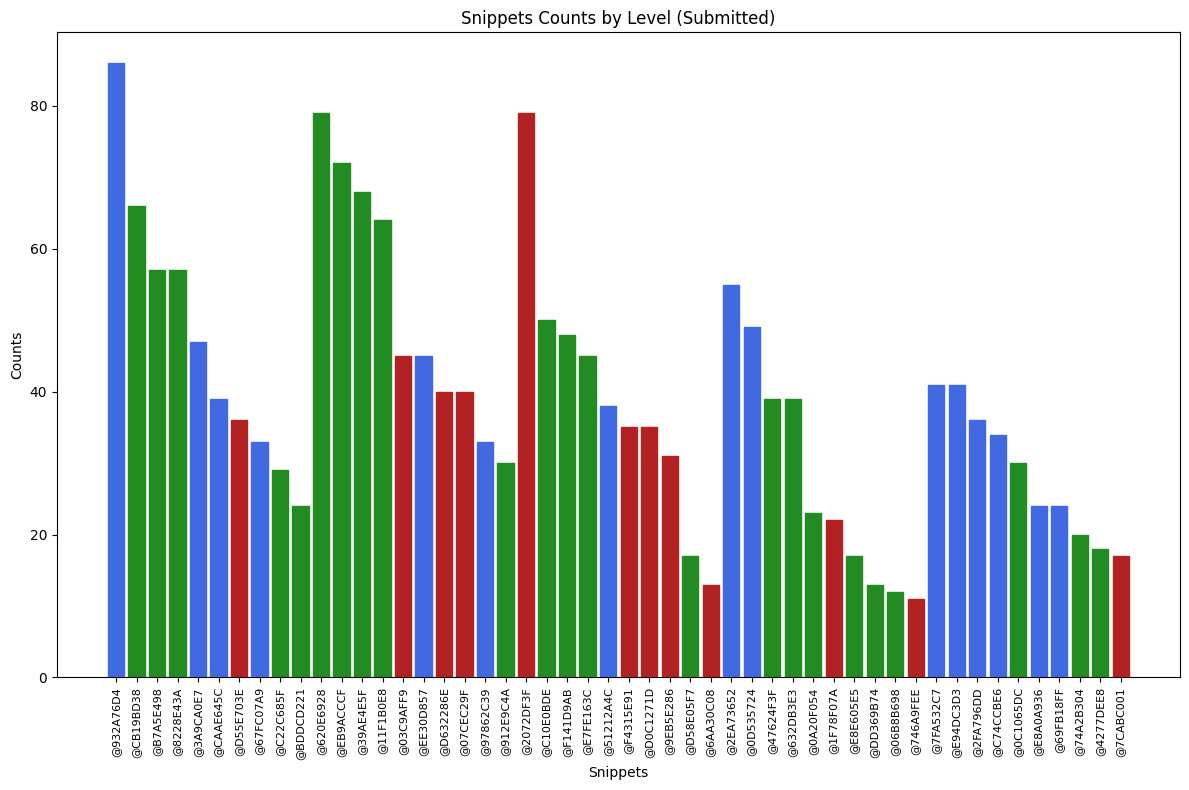

In [ ]:
category_colors = {'Great': 'royalblue', 'Good': 'forestgreen', 'Bad': 'firebrick'}

levels = []
snippets = []
counts = []
colors = []

for level, snippet_dict in combined_dict.items():
    for snippet, data in snippet_dict.items():
        levels.append(level)
        snippets.append(snippet)
        counts.append(data['count'])
        colors.append(category_colors[data['info']])

plt.figure(figsize=(12, 8), edgecolor='black')
bars = plt.bar(range(len(snippets)), counts, tick_label=snippets)

for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Snippets')
plt.ylabel('Counts')
plt.title('Snippets Counts by Level (Submitted)')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

plt.show()

### Per-Level Average Attributes

In [ ]:
parsed_json_objects = df['lvl1_FinalAttributes'].apply(lambda x: json.loads(x) if pd.notna(x) else None)

total_skill = {
    "research": 0,
    "resourceful": 0,
    "endurance": 0,
    "tech": 0,
    "social": 0,
    "trust": 0
}

num_items = 0
for skill_json in parsed_json_objects:
    if skill_json is not None:
        for key, value in skill_json.items():
            if key in total_skill and value is not None:
                total_skill[key] += value
        num_items += 1

average_scores = {key: value / num_items for key, value in total_skill.items()}

print(average_scores)





{'research': 0.9232245681381958, 'resourceful': 1.1516314779270633, 'endurance': 0.5604606525911708, 'tech': 0.7696737044145874, 'social': 0.9616122840690979, 'trust': 0.9059500959692899}


In [ ]:
attributes = ["research", "resourceful", "endurance", "tech", "social", "trust"]

average_scores_by_lvl = {}

for level in range(1, 7):
    level_column_name = f'lvl{level}_FinalAttributes'
    parsed_json_objects = df_completed[level_column_name].apply(lambda x: json.loads(x) if pd.notna(x) else None)

    total_skill = {attr: 0 for attr in attributes}
    num_items = 0

    for skill_json in parsed_json_objects:
        if skill_json is not None:
            for key, value in skill_json.items():
                if key in total_skill and value is not None:
                    total_skill[key] += value
            num_items += 1

    average_scores = {key: value / num_items for key, value in total_skill.items()}

    average_scores_by_lvl[level_column_name] = average_scores
print(average_scores_by_lvl)

{'lvl1_FinalAttributes': {'research': 2.0657894736842106, 'resourceful': 2.6052631578947367, 'endurance': 1.2236842105263157, 'tech': 1.5657894736842106, 'social': 2.0921052631578947, 'trust': 1.9736842105263157}, 'lvl2_FinalAttributes': {'research': 2.710526315789474, 'resourceful': 2.8421052631578947, 'endurance': 1.6578947368421053, 'tech': 2.5921052631578947, 'social': 2.25, 'trust': 2.473684210526316}, 'lvl3_FinalAttributes': {'research': 2.9473684210526314, 'resourceful': 3.3421052631578947, 'endurance': 2.3157894736842106, 'tech': 3.3815789473684212, 'social': 2.710526315789474, 'trust': 2.5526315789473686}, 'lvl4_FinalAttributes': {'research': 2.9342105263157894, 'resourceful': 3.3421052631578947, 'endurance': 2.3157894736842106, 'tech': 3.3815789473684212, 'social': 2.710526315789474, 'trust': 2.6842105263157894}, 'lvl5_FinalAttributes': {'research': 2.75, 'resourceful': 3.3684210526315788, 'endurance': 1.986842105263158, 'tech': 3.8157894736842106, 'social': 2.618421052631578

In [ ]:
import plotly.graph_objects as go

attributes = ["research", "resourceful", "endurance", "tech", "social", "trust"]
levels = list(average_scores_by_lvl.keys())

for lvl in levels:
    scores = average_scores_by_lvl[lvl]

    fig = go.Figure(go.Scatterpolar(
        r=list(scores.values()),
        theta=attributes + [attributes[0]],
        fill='toself',
        name=lvl
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(showticklabels=True, visible=True),
            angularaxis=dict(showticklabels=True),
        ),
        title=f'Average Attribute Scores - {lvl}',
    )

    fig.show()




compare submitted to collected